In [30]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve


In [31]:
# Load the datasets
# Load the datasets
train_df = pd.read_csv(r"/content/fraudTrain.csv")
test_df = pd.read_csv(r"/content/fraudTest.csv")

# Combine Train and Test Data
df = pd.concat([train_df, test_df], axis=0)

# Display basic information
print("Dataset shape:", df.shape)
df.head()

# Drop Unnecessary Columns
df = df.drop(['Unnamed: 0', 'trans_date_trans_time', 'cc_num', 'merchant', 'first',
              'last', 'street', 'city', 'state', 'zip', 'lat', 'long', 'job', 'dob',
              'trans_num', 'unix_time', 'merch_lat', 'merch_long'], axis=1)

# Handle missing values if any
print("Missing values per column:\n", df.isnull().sum())

# One-Hot Encoding for categorical variables
df_encoded = pd.get_dummies(df, drop_first=True)

# Separate Features and Target
X = df_encoded.drop('is_fraud', axis=1)  # Features
y = df_encoded['is_fraud']               # Target

# Split Data into Train and Test Sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Feature Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


Dataset shape: (1852394, 23)
Missing values per column:
 category    0
amt         0
gender      0
city_pop    0
is_fraud    0
dtype: int64



=== Logistic Regression ===
Accuracy: 0.9943064750350447
Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00    552781
           1       0.00      0.00      0.00      2938

    accuracy                           0.99    555719
   macro avg       0.50      0.50      0.50    555719
weighted avg       0.99      0.99      0.99    555719



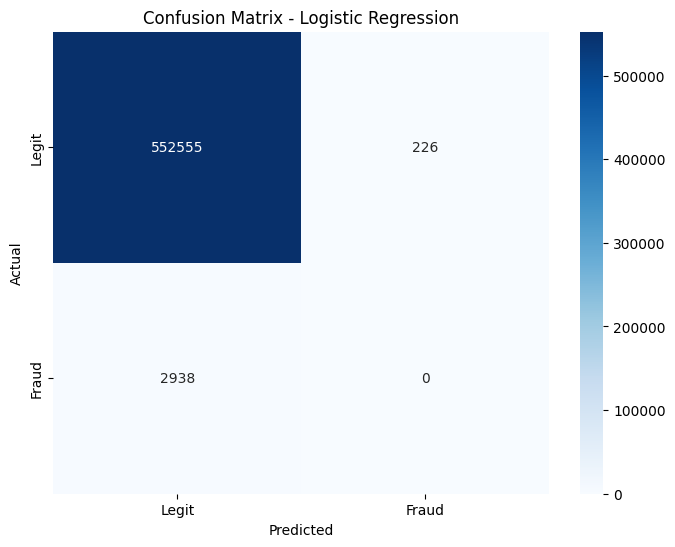

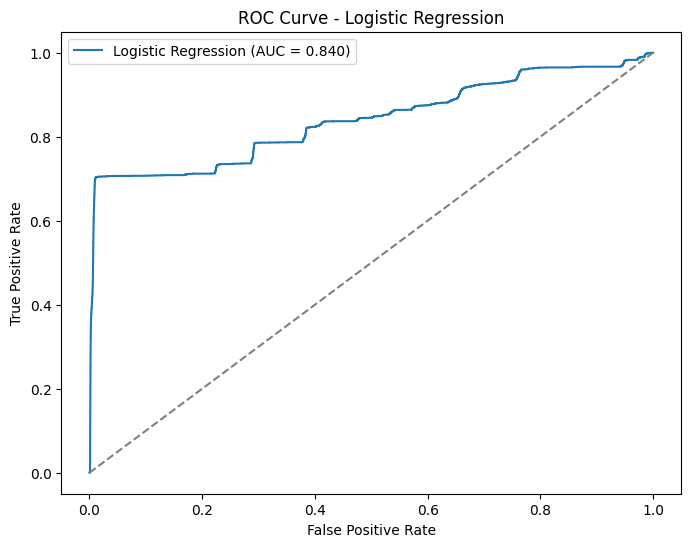


=== Decision Tree ===
Accuracy: 0.996275095866796
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    552781
           1       0.65      0.64      0.64      2938

    accuracy                           1.00    555719
   macro avg       0.82      0.82      0.82    555719
weighted avg       1.00      1.00      1.00    555719



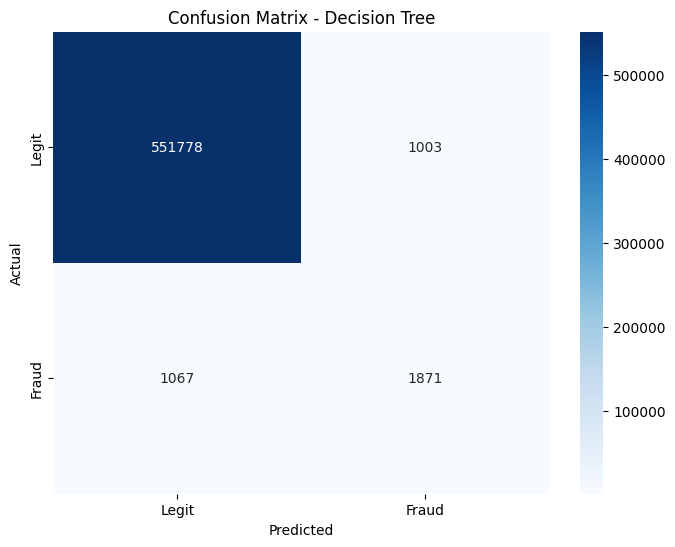

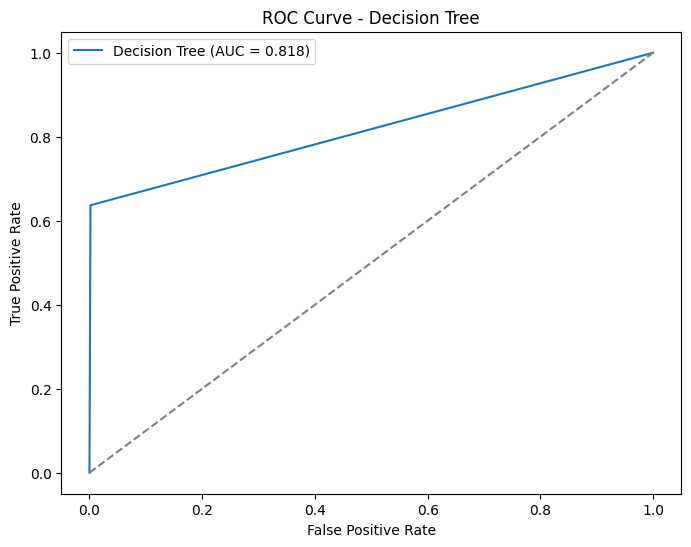


=== Random Forest ===
Accuracy: 0.9973097914593526
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    552781
           1       0.80      0.65      0.72      2938

    accuracy                           1.00    555719
   macro avg       0.90      0.83      0.86    555719
weighted avg       1.00      1.00      1.00    555719



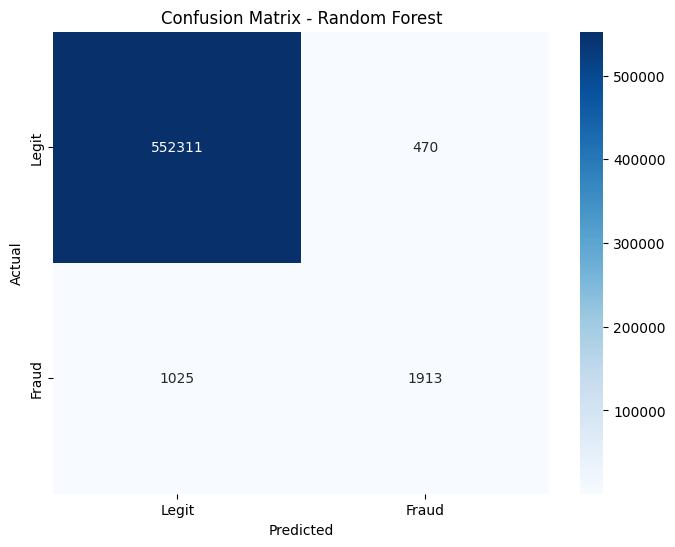

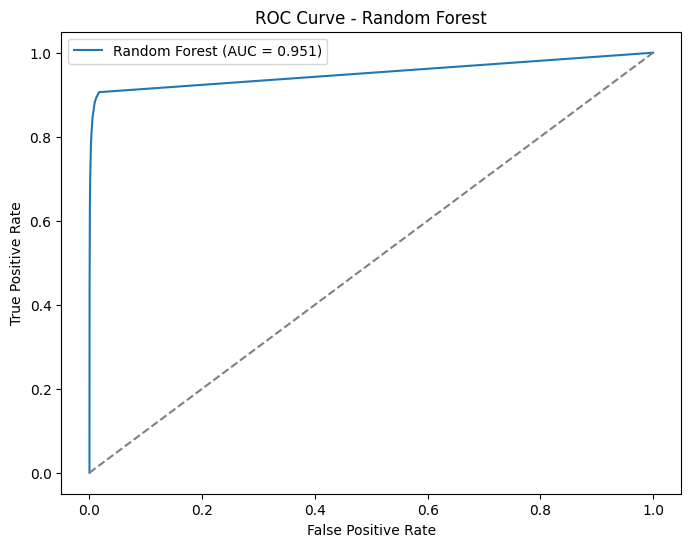

In [32]:
# Define models
models = {
    "Logistic Regression": LogisticRegression(random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42)
}

# Train and evaluate each model
for name, model in models.items():
    print(f"\n=== {name} ===")
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)

    # Evaluation Metrics
    print("Accuracy:", accuracy_score(y_test, predictions))
    print("Classification Report:\n", classification_report(y_test, predictions))

    # Confusion Matrix
    cm = confusion_matrix(y_test, predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Legit", "Fraud"], yticklabels=["Legit", "Fraud"])
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # ROC Curve
    if hasattr(model, "predict_proba"):  # Check if the model supports predict_proba
        fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
        auc_score = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    else:  # Use decision_function for Logistic Regression
        fpr, tpr, _ = roc_curve(y_test, model.decision_function(X_test))
        auc_score = roc_auc_score(y_test, model.decision_function(X_test))

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc_score:.3f})")
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve - {name}")
    plt.legend()
    plt.show()


In [33]:
# Function to predict fraud for a new transaction
def predict_fraud(transaction_data, model_name="Random Forest"):
    # Select model
    model = models[model_name]

    # Ensure input matches feature columns
    input_data = pd.DataFrame([transaction_data], columns=X.columns)
    input_data = scaler.transform(input_data)
    prediction = model.predict(input_data)

    return "Fraudulent" if prediction[0] == 1 else "Legitimate"


In [34]:
# Get user input
def get_user_input():
    # Based on feature importance, we will focus on `amt` and `city_pop` for high-risk fraud
    transaction_data = {col: float(input(f"Enter {col}: ")) for col in X.columns}
    return transaction_data


In [39]:
# Function to classify transaction based on fraud probability and threshold
def classify_transaction(fraud_probability, threshold=0.2):
    """
    Classifies a transaction as fraudulent or legitimate based on a given fraud probability and threshold.

    Parameters:
    fraud_probability (float): The predicted probability of fraud.
    threshold (float): The threshold for classifying a transaction as fraudulent. Default is 0.2.

    Returns:
    str: "Fraudulent" if the fraud probability is greater than or equal to the threshold, "Legitimate" otherwise.
    """
    if fraud_probability >= threshold:
        return "Fraudulent"
    else:
        return "Legitimate"

# Function to predict fraud probability for a new transaction (with model probabilities)
def predict_fraud_prob(transaction_data, model_name="Random Forest"):
    model = models[model_name]

    # Ensure input matches feature columns
    input_data = pd.DataFrame([transaction_data], columns=X.columns)
    input_data = scaler.transform(input_data)

    # Get the probability of fraud (the second column is the probability of class 1, i.e., fraud)
    prob_fraud = model.predict_proba(input_data)[:, 1]

    return prob_fraud[0]

# Function to simulate a high-risk fraud case based on important features
def simulate_high_risk_case():
    # Here, setting `amt` high and `city_pop` to a larger value will trigger a likely fraud case.
    user_input = {
        'amt': 50000,  # High transaction amount
        'city_pop': 5000,  # Large city population
        'category_food_dining': 0,
        'category_gas_transport': 0,
        'category_grocery_net': 0,
        'category_grocery_pos': 0,
        'category_health_fitness': 0,
        'category_home': 0,
        'category_kids_pets': 0,
        'category_misc_net': 1,
        'category_misc_pos': 0,
        'category_personal_care': 0,
        'category_shopping_net': 1,
        'category_shopping_pos': 0,
        'category_travel': 1,
        'gender_M': 1
    }
    return user_input

# Function to get user input for prediction
def get_user_input():
    transaction_data = {col: float(input(f"Enter {col}: ")) for col in X.columns}
    return transaction_data

# Get user input for fraud prediction
user_input = get_user_input()

# Get the probability of fraud for the input
probability = predict_fraud_prob(user_input)
print("\nProbability of Fraud:", probability)

# Define fraud threshold (lower threshold for more sensitivity)
threshold = 0.2  # For example, consider anything above 20% as fraud

# Classify the transaction based on fraud probability
result = classify_transaction(probability, threshold)
print("\nThe transaction is:", result)


Enter amt: 50000
Enter city_pop: 5000
Enter category_food_dining: 0
Enter category_gas_transport: 0
Enter category_grocery_net: 0
Enter category_grocery_pos: 0
Enter category_health_fitness: 0
Enter category_home: 0
Enter category_kids_pets: 0
Enter category_misc_net: 1
Enter category_misc_pos: 0
Enter category_personal_care: 0
Enter category_shopping_net: 1
Enter category_shopping_pos: 0
Enter category_travel: 1
Enter gender_M: 1

Probability of Fraud: 0.02

The transaction is: Legitimate
